## ***STEP 1: Load and Preprocess the LOB Data***

In [ ]:
import pandas as pd
import numpy as np

lob = pd.read_csv(r"D:\me\Mohamed\Quant finance\Quant Project\Data\FROG\FROG_2025-04-03 00_00_00+00_00.csv")
lob['ts_event'] = pd.to_datetime(lob['ts_event'])

# Convert nanodollar prices to dollars
for i in range(10):
    lob[f'ask_px_{i:02}'] *= 1e-9
    lob[f'bid_px_{i:02}'] *= 1e-9

ask_px_cols = [f'ask_px_{i:02}' for i in range(10)]
ask_sz_cols = [f'ask_sz_{i:02}' for i in range(10)]

# Group by minute
lob['minute'] = lob['ts_event'].dt.floor('min')
minute_snapshots = lob.groupby('minute').last().reset_index()

print(minute_snapshots[['minute'] + ask_px_cols + ask_sz_cols].head())

                     minute     ask_px_00     ask_px_01     ask_px_02  \
0 2025-04-03 13:30:00+00:00  3.150000e-08  3.154000e-08  3.155000e-08   
1 2025-04-03 13:31:00+00:00  3.187000e-08  3.199000e-08  3.200000e-08   
2 2025-04-03 13:32:00+00:00  3.187000e-08  3.199000e-08  3.200000e-08   
3 2025-04-03 13:33:00+00:00  3.187000e-08  3.199000e-08  3.200000e-08   
4 2025-04-03 13:34:00+00:00  3.187000e-08  3.199000e-08  3.200000e-08   

      ask_px_03     ask_px_04     ask_px_05     ask_px_06     ask_px_07  \
0  3.187000e-08  3.199000e-08  3.200000e-08  3.205000e-08  3.213000e-08   
1  3.210000e-08  3.213000e-08  3.219000e-08  3.227000e-08  3.250000e-08   
2  3.210000e-08  3.213000e-08  3.219000e-08  3.227000e-08  3.250000e-08   
3  3.213000e-08  3.219000e-08  3.221000e-08  3.227000e-08  3.250000e-08   
4  3.201000e-08  3.213000e-08  3.219000e-08  3.221000e-08  3.249000e-08   

      ask_px_08  ...  ask_sz_00  ask_sz_01  ask_sz_02  ask_sz_03  ask_sz_04  \
0  3.227000e-08  ...        225

## ***STEP 2: Simulate Market Buy Orders***

In [23]:
def simulate_buy_order(ask_prices, ask_sizes, x):
    remaining = x
    total_cost = 0.0
    for price, size in zip(ask_prices, ask_sizes):
        if remaining <= 0:
            break
        buy_size = min(remaining, size)
        total_cost += buy_size * price
        remaining -= buy_size
    if remaining > 0:
        return np.nan
    return total_cost / x

order_sizes = list(range(50, 1001, 50))
results = []

for _, row in minute_snapshots.iterrows():
    t = row['minute']
    ask_prices = [row[f'ask_px_{i:02}'] for i in range(10)]
    ask_sizes = [row[f'ask_sz_{i:02}'] for i in range(10)]
    bid0 = row['bid_px_00']
    ask0 = row['ask_px_00']
    if pd.isna(bid0) or pd.isna(ask0):
        continue
    mid_price = 0.5 * (bid0 + ask0)
    for size in order_sizes:
        vwap = simulate_buy_order(ask_prices, ask_sizes, size)
        if not np.isnan(vwap):
            slippage = vwap - mid_price
            results.append({'minute': t, 'order_size': size, 'vwap': vwap, 'mid': mid_price, 'slippage': slippage})

impact_df = pd.DataFrame(results)
print(impact_df.head())

                     minute  order_size          vwap           mid  \
0 2025-04-03 13:30:00+00:00          50  3.150000e-08  3.128500e-08   
1 2025-04-03 13:30:00+00:00         100  3.150000e-08  3.128500e-08   
2 2025-04-03 13:30:00+00:00         150  3.150000e-08  3.128500e-08   
3 2025-04-03 13:30:00+00:00         200  3.150000e-08  3.128500e-08   
4 2025-04-03 13:30:00+00:00         250  3.152272e-08  3.128500e-08   

       slippage  
0  2.150000e-10  
1  2.150000e-10  
2  2.150000e-10  
3  2.150000e-10  
4  2.377200e-10  


## ***STEP 3: Fit Slippage Models***

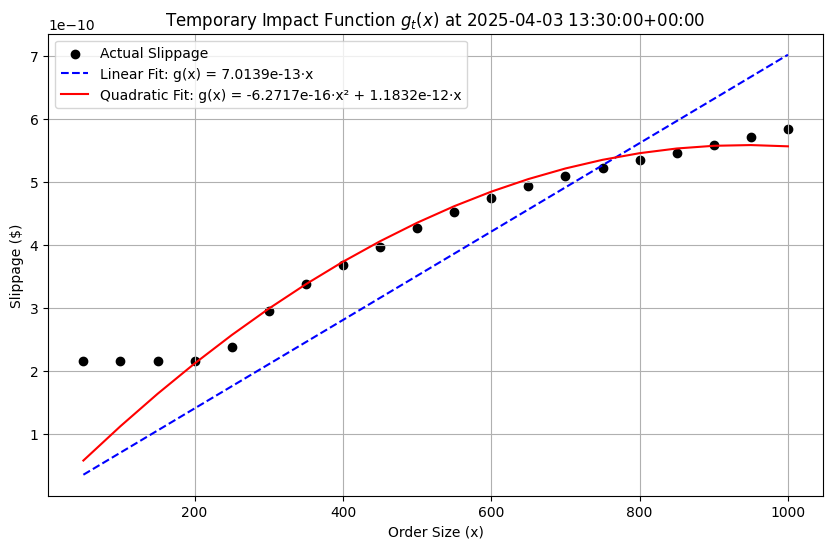

In [24]:
def linear_model(x, beta):
    return beta * x

def quadratic_model(x, alpha, beta):
    return alpha * x**2 + beta * x

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

target_minute = impact_df['minute'].iloc[0]
minute_data = impact_df[impact_df['minute'] == target_minute]

x_data = minute_data['order_size'].values
y_data = minute_data['slippage'].values

params_linear, _ = curve_fit(linear_model, x_data, y_data)
y_pred_linear = linear_model(x_data, *params_linear)

params_quad, _ = curve_fit(quadratic_model, x_data, y_data)
y_pred_quad = quadratic_model(x_data, *params_quad)

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Actual Slippage', color='black')
plt.plot(x_data, y_pred_linear, label=f'Linear Fit: g(x) = {params_linear[0]:.4e}·x', linestyle='--', color='blue')
plt.plot(x_data, y_pred_quad, label=f'Quadratic Fit: g(x) = {params_quad[0]:.4e}·x² + {params_quad[1]:.4e}·x', color='red')
plt.title(f"Temporary Impact Function $g_t(x)$ at {target_minute}")
plt.xlabel("Order Size (x)")
plt.ylabel("Slippage ($)")
plt.legend()
plt.grid(True)
plt.show()

## ***STEP 4: Fit gₜ(x) for All Minutes***

In [25]:
alpha_list = []
beta_list = []
minutes = impact_df['minute'].unique()

for t in minutes:
    minute_data = impact_df[impact_df['minute'] == t]
    x = minute_data['order_size'].values
    y = minute_data['slippage'].values
    try:
        (a, b), _ = curve_fit(lambda x, a, b: a * x**2 + b * x, x, y)
    except:
        a, b = 0, np.mean(y) / np.mean(x)
    alpha_list.append(a)
    beta_list.append(b)

alpha = np.array(alpha_list)
beta = np.array(beta_list)

## ***STEP 5: Solve the Optimal Execution Problem with CVXPY***

In [26]:
import cvxpy as cp

S = 10000
N = len(alpha)

alpha = np.maximum(alpha, 1e-12)
beta = np.array(beta)

x = cp.Variable(N)
alpha_param = cp.Constant(alpha)
beta_param = cp.Constant(beta)

objective = cp.Minimize(cp.sum(alpha_param * cp.square(x) + beta_param * x))
constraints = [cp.sum(x) == S, x >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

optimal_allocation = x.value
print("First 10 min allocations:", optimal_allocation[:10])

First 10 min allocations: [25.64102186 25.64102258 25.64102258 25.64102269 25.64102132 25.64102149
 25.64102307 25.64102127 25.64102197 25.64102205]


d:\Python\Python312\Lib\site-packages\cvxpy\expressions\expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
d:\Python\Python312\Lib\site-packages\cvxpy\expressions\expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


## ***STEP 6: Visualize Execution Schedule***

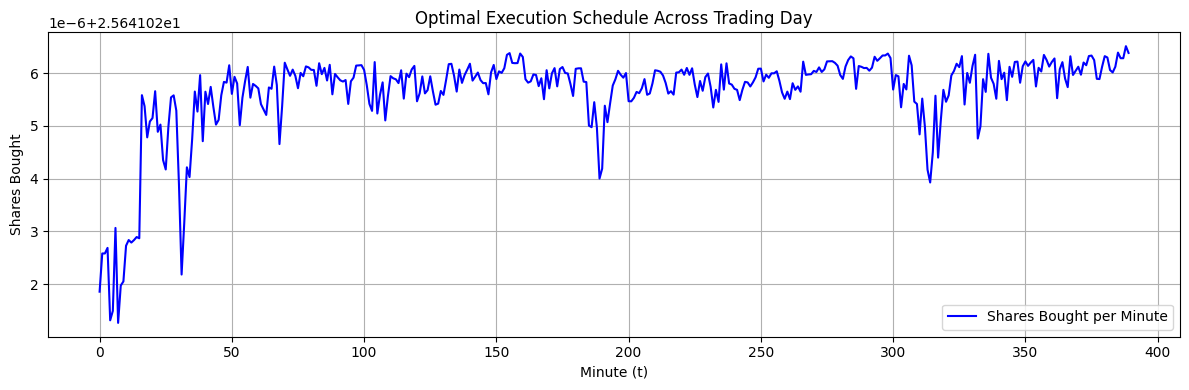

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(optimal_allocation, color='blue', label='Shares Bought per Minute')
plt.title("Optimal Execution Schedule Across Trading Day")
plt.xlabel("Minute (t)")
plt.ylabel("Shares Bought")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## ***STEP 7: Compare with Uniform Execution***

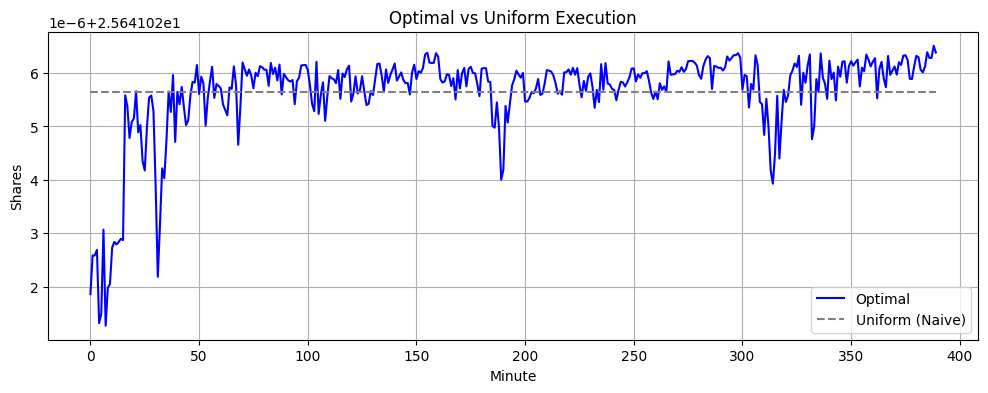

In [ ]:
uniform = np.ones_like(optimal_allocation) * (S / N)

plt.figure(figsize=(12, 4))
plt.plot(optimal_allocation, label='Optimal', color='blue')
plt.plot(uniform, label='Uniform (Naive)', linestyle='--', color='gray')
plt.title("Optimal vs Uniform Execution")
plt.xlabel("Minute")
plt.ylabel("Shares")
plt.legend()
plt.grid(True)
plt.show()